In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import re

sns.set(style="whitegrid")

csv_path = "wandb_data/"

In [5]:
metrics = ['score', 'regret', 'loss', 'exploration_rate']
envs = ['reg', 'mnist', 'nn']

def load_data(folder):
    data = {}
    for _env in envs:
        _data = []
        for _metric in metrics:
            path = f'{csv_path}{folder}{_env}/{_metric}.csv'
            df = pd.read_csv(path)
            _data.append((df, _metric))
        data[_env] = _data
    return data

data_p1o = load_data('p1o/')
data_qyg = load_data('qyg/')

# reg = data['reg']
# mnist = data['mnist']
# nn = data['nn']
# print(reg[0]) # score
# print(reg[0][0]) # df
# print(reg[0][1]) # metric

In [6]:
data_p1o['reg'][0][0].head(3)

,Step,noisy_net: false - score,noisy_net: false - score__MIN,noisy_net: false - score__MAX,noisy_net: true - score,noisy_net: true - score__MIN,noisy_net: true - score__MAX
0,50,0.510234,0.298476,0.697431,0.477637,0.196577,0.728522
1,100,0.525440,0.267389,0.713413,0.483085,0.155528,0.770533
2,150,0.620304,0.492680,0.717982,0.661149,0.435181,0.792092


In [7]:
nonoisy = load_data('no-noisy/')
nonoisy['nn'][0][0].head(3)
# nonoisy['nn'][0][0].iloc[:, 0].head(3)
# list(nonoisy['nn'][0][0].columns.values)

,Step,env_id: NNBandit-v0 - score,env_id: NNBandit-v0 - score__MIN,env_id: NNBandit-v0 - score__MAX
0,50,-0.029499,-0.171092,0.163663
1,100,-0.036624,-0.202226,0.179104
2,150,0.132458,-0.019962,0.240213


In [8]:
nonoisy = load_data('no-noisy/')
for dataset in nonoisy.values():
    for df, metric in dataset:
        col_map = ['no', 'no__MIN', 'no__MAX']
        for i in range(3):
            # print(f"Renaming: {df.columns.values[1]} -> {col_map[i]}")
            df[col_map[i]] = df.pop(df.columns.values[1])


nonoisy['nn'][0][0].head(3)

,Step,no,no__MIN,no__MAX
0,50,-0.029499,-0.171092,0.163663
1,100,-0.036624,-0.202226,0.179104
2,150,0.132458,-0.019962,0.240213


In [9]:
def rename(dataset):
    for df, metric in dataset:
        cols = [
            (f'noisy_net: true - {metric}', 'yes'),
            (f'noisy_net: true - {metric}__MIN', 'yes__MIN'),
            (f'noisy_net: true - {metric}__MAX', 'yes__MAX'),
            (f'noisy_net: false - {metric}', 'no'),
            (f'noisy_net: false - {metric}__MIN', 'no__MIN'),
            (f'noisy_net: false - {metric}__MAX', 'no__MAX'),
        ]
    
        for old, new in cols:
            if old in df.columns:
                df[new] = df.pop(old)
        # df.dropna(subset=['yes__MIN', 'yes__MAX'], inplace=True)

for dataset in data_p1o.values():
    rename(dataset)
for dataset in data_qyg.values():
    rename(dataset)

In [10]:
combined_data = {}

for env in envs:
    combined_env_data = []
    for (df1, metric), (df2, _) in zip(data_p1o[env], data_qyg[env]):
        df_merged = df1.merge(df2, on='Step', suffixes=('_p1o', '_qyg'))

        df_combined = pd.DataFrame()
        df_combined['Step'] = df_merged['Step']
        df_combined['yes'] = df_merged[['yes_p1o', 'yes_qyg']].mean(axis=1)
        df_combined['yes__MIN'] = df_merged[['yes__MIN_p1o', 'yes__MIN_qyg']].min(axis=1)
        df_combined['yes__MAX'] = df_merged[['yes__MAX_p1o', 'yes__MAX_qyg']].max(axis=1)
        df_combined['no'] = df_merged[['no_p1o', 'no_qyg']].mean(axis=1)
        df_combined['no__MIN'] = df_merged[['no__MIN_p1o', 'no__MIN_qyg']].min(axis=1)
        df_combined['no__MAX'] = df_merged[['no__MAX_p1o', 'no__MAX_qyg']].max(axis=1)

        combined_env_data.append((df_combined, metric))
    combined_data[env] = combined_env_data

# combined_data['mnist'], combined_data['reg'], combined_data['nn']
# list of (df, metric)

In [16]:
for _env in envs:
    for i, _metric in enumerate(metrics):
        _df = combined_data[_env][i][0]
        _nonoisy_df = nonoisy[_env][i][0]
        common_cols = _df.columns.intersection(_nonoisy_df.columns)
        _df[common_cols] = _nonoisy_df[common_cols]
        combined_data[_env][i] = (_df, _metric)

combined_data['mnist'][0]

(    Step       yes  yes__MIN  yes__MAX        no  no__MIN  no__MAX
 0     50 -0.784010     -1.00      0.84 -0.744828    -1.00     0.40
 1    100 -0.791691     -1.00      0.68 -0.733793    -1.00     0.48
 2    150 -0.090676     -1.00      0.96 -0.224828    -0.96     0.52
 3    200  0.819034     -0.88      1.00  0.388966     0.08     0.60
 4    250  1.000000      1.00      1.00  0.528276     0.32     0.76
 5    300  1.000000      1.00      1.00  0.715862     0.48     0.88
 6    350  1.000000      1.00      1.00  0.891034     0.80     0.96
 7    400  1.000000      1.00      1.00  1.000000     1.00     1.00
 8    450  1.000000      1.00      1.00  1.000000     1.00     1.00
 9    500  1.000000      1.00      1.00  1.000000     1.00     1.00
 10   550  1.000000      1.00      1.00  1.000000     1.00     1.00
 11   600  1.000000      1.00      1.00  1.000000     1.00     1.00
 12   650  1.000000      1.00      1.00  1.000000     1.00     1.00
 13   700  1.000000      1.00      1.00  1.00000

In [115]:
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ax = axes[0, 0]
# df = combined_data['reg'][0][0]
# ndf = nonoisy['reg'][0][0]
# sns.lineplot(data=df, x='Step', y='yes', label=f'{metric.capitalize()} NoisyNet', ax=ax)
# sns.lineplot(data=ndf, x='Step', y='no', label=f'{metric.capitalize()} Non-NoisyNet', ax=ax)
# ax.fill_between(df['Step'], df['yes__MIN'], df['yes__MAX'], alpha=0.3)
# ax = axes[0, 1]
# df = combined_data['reg'][1][0]
# ndf = nonoisy['reg'][1][0]
# sns.lineplot(data=df, x='Step', y='yes', label=f'{metric.capitalize()} NoisyNet', ax=ax)
# sns.lineplot(data=ndf, x='Step', y='no', label=f'{metric.capitalize()} Non-NoisyNet', ax=ax)
# ax.fill_between(df['Step'], df['yes__MIN'], df['yes__MAX'], alpha=0.3)
# ax = axes[1, 0]
# df = combined_data['reg'][2][0]
# ndf = nonoisy['reg'][2][0]
# sns.lineplot(data=df, x='Step', y='yes', label=f'{metric.capitalize()} NoisyNet', ax=ax)
# sns.lineplot(data=ndf, x='Step', y='no', label=f'{metric.capitalize()} Non-NoisyNet', ax=ax)
# ax.fill_between(df['Step'], df['yes__MIN'], df['yes__MAX'], alpha=0.3)
# ax = axes[1, 1]
# df = combined_data['reg'][3][0]
# ndf = nonoisy['reg'][3][0]
# sns.lineplot(data=df, x='Step', y='yes', label=f'{metric.capitalize()} NoisyNet', ax=ax)
# # sns.lineplot(data=ndf, x='Step', y='no', label=f'{metric.capitalize()} Non-NoisyNet', ax=ax)
# ax.fill_between(df['Step'], df['yes__MIN'], df['yes__MAX'], alpha=0.3)

In [157]:
def plot_metric_grid(dataset, suptitle=""):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"{suptitle} Metrics", fontsize=16)

    metric_map = {
        'score':       (0, 0, 'Score', 'Score', 'lower right'),
        'loss':        (0, 1, 'Loss', 'Loss', 'upper right'),
        'regret':      (1, 0, 'Regret', 'Regret', 'lower right'),
        'exploration_rate': (1, 1, 'Exploration Rate', 'Exploration Rate', 'upper right'),
    }

    for df, metric in dataset:
        row, col, title, ylabel, legend_loc = metric_map[metric]
        ax = axes[row, col]

        sns.lineplot(data=df, x='Step', y='yes', label='NoisyNet', ax=ax)
        sns.lineplot(data=df, x='Step', y='no', label='Non-NoisyNet', ax=ax)
        fill_mask = df[['yes__MIN', 'yes__MAX']].notna().all(axis=1)
        ax.fill_between(df['Step'][fill_mask], df['yes__MIN'][fill_mask], df['yes__MAX'][fill_mask], alpha=0.3)
        # ax.fill_between(df['Step'], df['yes__MIN'], df['yes__MAX'], alpha=0.3)
        ax.fill_between(df['Step'], df['no__MIN'], df['no__MAX'], alpha=0.3)

        ax.set_title(suptitle)
        ax.set_xlabel('Step')
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.legend(title='Network', loc=legend_loc)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"{suptitle} metrics.png", dpi=300, bbox_inches='tight')
    
    plt.show()

In [19]:
def plot_metric_grid(dataset, suptitle=""):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    fig.suptitle(f"{suptitle} Metrics", fontsize=16)

    metric_map = {
        'score':       (0, 'Score', 'Score', 'lower right'),
        'loss':        (1, 'Loss', 'Loss', 'upper right'),
        'regret':      (1, 'Regret', 'Regret', 'best'),
        'exploration_rate': (2, 'Exploration Rate', 'Exploration Rate', 'upper right'),
    }

    for df, metric in dataset:
        if metric == 'loss':
            continue
        col, title, ylabel, legend_loc = metric_map[metric]
        ax = axes[col]

        sns.lineplot(data=df, x='Step', y='yes', label='NoisyNet', ax=ax)
        sns.lineplot(data=df, x='Step', y='no', label='Non-NoisyNet', ax=ax)
        fill_mask = df[['yes__MIN', 'yes__MAX']].notna().all(axis=1)
        ax.fill_between(df['Step'][fill_mask], df['yes__MIN'][fill_mask], df['yes__MAX'][fill_mask], alpha=0.3)
        # ax.fill_between(df['Step'], df['yes__MIN'], df['yes__MAX'], alpha=0.3)
        ax.fill_between(df['Step'], df['no__MIN'], df['no__MAX'], alpha=0.3)

        ax.set_title(f'{metric.capitalize()}')
        ax.set_xlabel('Step')
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.legend(loc=legend_loc)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"{suptitle} metrics.png", dpi=300, bbox_inches='tight')
    
    plt.show()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


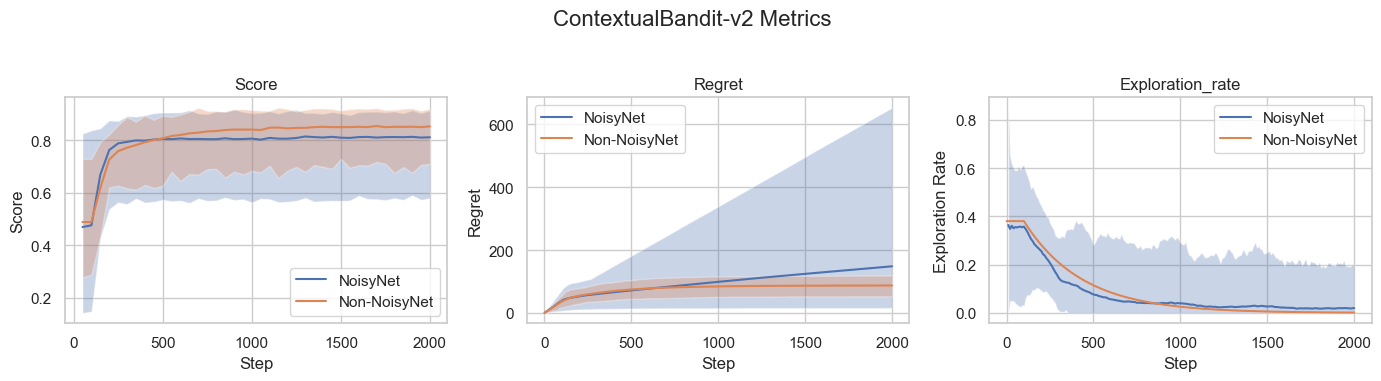

In [20]:
plot_metric_grid(combined_data['reg'], suptitle="ContextualBandit-v2")

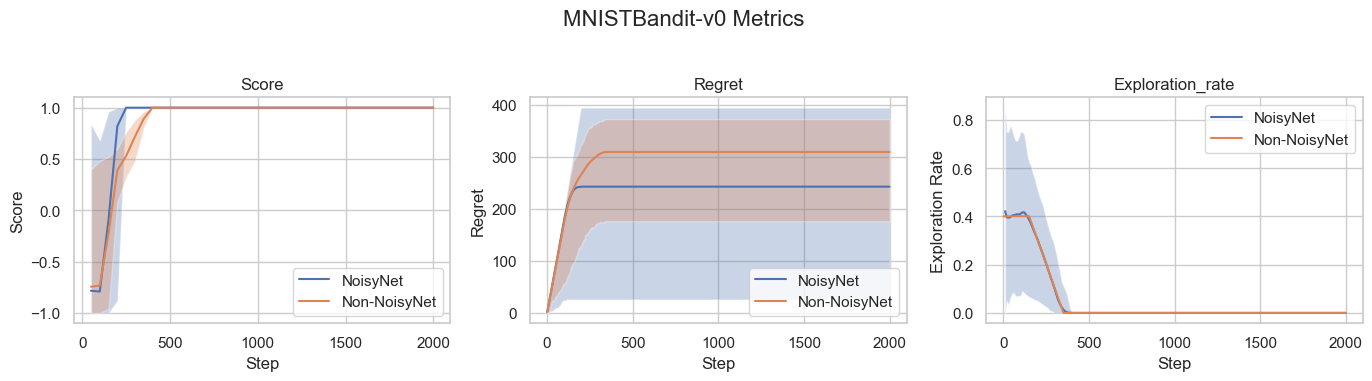

In [175]:
plot_metric_grid(combined_data['mnist'], suptitle="MNISTBandit-v0")

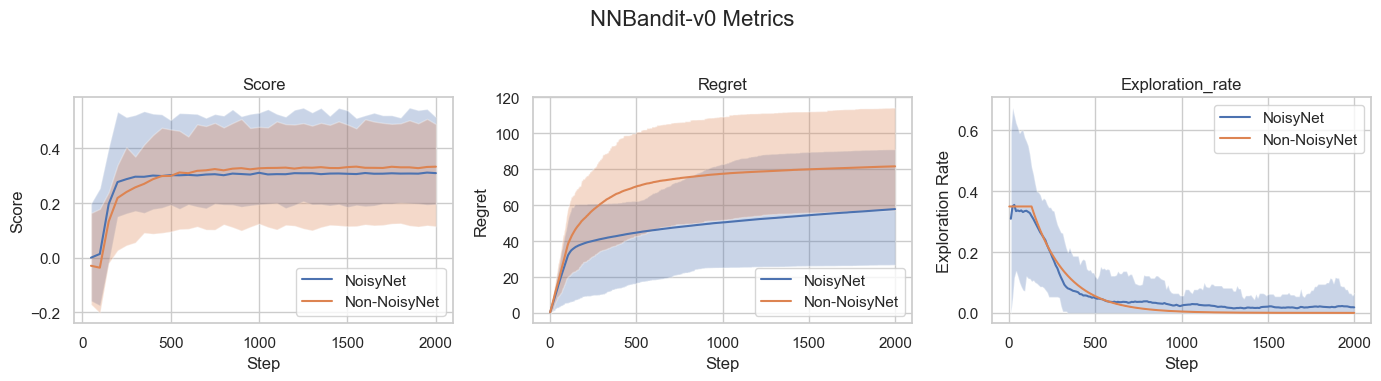

In [176]:
plot_metric_grid(combined_data['nn'], suptitle="NNBandit-v0")